In [14]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import time
from IPython.display import Image, display
import operator

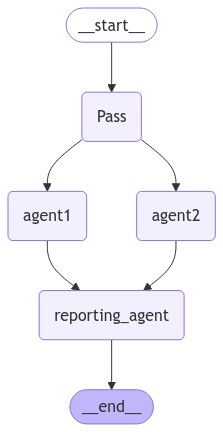

In [15]:
class State(TypedDict):
    message: Annotated[list[str], add_messages]

def get_agent1(state: State):
    print('This is agent 1, doing calculation')
    time.sleep(1)
    print('This is agent 1 reporting.....')
    return state



def get_agent2(state: State):
    print('This is agent 2, doing calculation')
    time.sleep(1)
    print('This is agent 2 reporting.....')
    return state
    



def get_reporting_agent(state: State):
    print('This is reporting agent, doing reporting')
    time.sleep(1)
    print('This is reporting agent reporting.....')
    return state

workflow = StateGraph(State)
workflow.add_node('Pass', lambda state: state)
workflow.add_edge(START, 'Pass')

workflow.add_node('agent1', get_agent1)
workflow.add_edge('Pass', 'agent1')

workflow.add_node('agent2', get_agent2)
workflow.add_edge('Pass', 'agent2')

workflow.add_node('reporting_agent', get_reporting_agent)
workflow.add_edge('agent1', 'reporting_agent')
workflow.add_edge('agent2', 'reporting_agent')

workflow.add_edge('reporting_agent', END)

app = workflow.compile()  # Compile the workflow

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))



In [16]:
app.invoke({'message': ['Hello, world!']})

This is agent 1, doing calculation
This is agent 2, doing calculation
This is agent 1 reporting.....
This is agent 2 reporting.....
This is reporting agent, doing reporting
This is reporting agent reporting.....


{'message': [HumanMessage(content='Hello, world!', additional_kwargs={}, response_metadata={}, id='fddc4bfe-c541-4416-a96c-f772b1d9dca0')]}

In [18]:
FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company (whose symbol is {company}) performance based on stock prices, technical indicators, financial metrics and News.
Your task is to provide a comprehensive summary of the fundamental analysis for a given stock.

You have access to the following tools:
1. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like RSI, MACD, Drawdown and VWAP.
3. **get_news_sentiment**: Summarize latest news and retirieves latest news.

### Your Task:
1. **Input Stock Symbol**: Use the provided stock symbol to query the tools and gather the relevant information.
2. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
3. **Provide Summary**: Write a concise, well-structured summary that highlights:


### Constraints:
- Use only the data provided by the tools.
- Avoid speculative language; focus on observable data and trends.
- If any tool fails to provide data, clearly state that in your summary.

"""

from langchain_openai import ChatOpenAI
import dotenv
dotenv.load_dotenv()
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Union, Dict
from langchain_core.messages import SystemMessage

@tool
def get_stock_prices(ticker: str) -> Union[Dict]:
    """Fetches historical stock price data and technical indicator for a given ticker."""
    return {'stock_price': 'All time high', 'technical indicator': 'RSI at 65'}
    
@tool
def get_news_sentiment(ticker: str) -> Union[Dict]:
    """Fetches key financial ratios for a given ticker."""
    return {
        'news_sentiment':'will aquire tiktok next month, Positve',
    }

    
class State(TypedDict):
    messages: Annotated[list, add_messages]
    stock: str
    
graph_builder = StateGraph(State)

tools = [get_stock_prices, get_news_sentiment]
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tool = llm.bind_tools(tools)

def fundamental_analyst(state: State):
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=state['stock'])),
    ]  + state['messages']
    return {
        'messages': llm_with_tool.invoke(messages)
    }
    
graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_edge(START, 'fundamental_analyst')
graph_builder.add_node(ToolNode(tools))
graph_builder.add_conditional_edges('fundamental_analyst', tools_condition)
graph_builder.add_edge('tools', 'fundamental_analyst')

# HumanMessage(content=)
# graph_builder.add_edge('fundamental_analyst', END)
graph = graph_builder.compile()
events = graph.stream({'messages':[('user', 'Should I buy this stock?')],
 'stock': 'TSLA'}, stream_mode='values')
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()
    

================================ Human Message =================================

Should I buy this stock?
================================== Ai Message ==================================

To provide a thorough analysis of whether you should consider buying Tesla (TSLA) stock, I will gather the latest stock prices, technical indicators, and relevant news sentiment. Please hold on for a moment while I retrieve this information.
Tool Calls:
  get_stock_prices (call_cHv7KSYBPYFJsTffKRUEn6XN)
 Call ID: call_cHv7KSYBPYFJsTffKRUEn6XN
  Args:
    ticker: TSLA
  get_news_sentiment (call_NxiOAKFTIcc2iZUyOljEaxYv)
 Call ID: call_NxiOAKFTIcc2iZUyOljEaxYv
  Args:
    ticker: TSLA
================================= Tool Message =================================
Name: get_news_sentiment

{"news_sentiment": "will aquire tiktok next month, Positve"}
================================== Ai Message ==================================

### Fundamental Analysis Summary for Tesla (TSLA)

1. **Stock Price Perfo

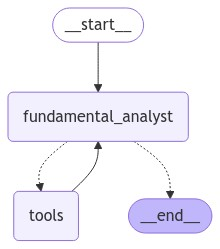

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass